In [1]:
import dask
from dask.distributed import Client
import dask_jobqueue
import discretize
from discretize.utils import mkvc
# import deepdish as dd
import h5py
import json
import matplotlib.pyplot as plt
from matplotlib import cm as cmap
from matplotlib.colors import LogNorm, Normalize
import numpy as np
import os
import pandas as pd
import scipy.sparse as sp

import casingSimulations as casing_sim
from SimPEG import maps
from SimPEG.electromagnetics import time_domain as tdem
from pymatsolver import Pardiso

np.random.seed(29)

In [2]:
data_directory = "./experiment1"

In [3]:
from matplotlib import rcParams
rcParams["font.size"] = 16

In [4]:
df = pd.read_hdf(f"{data_directory}/trial_data.h5", "data")

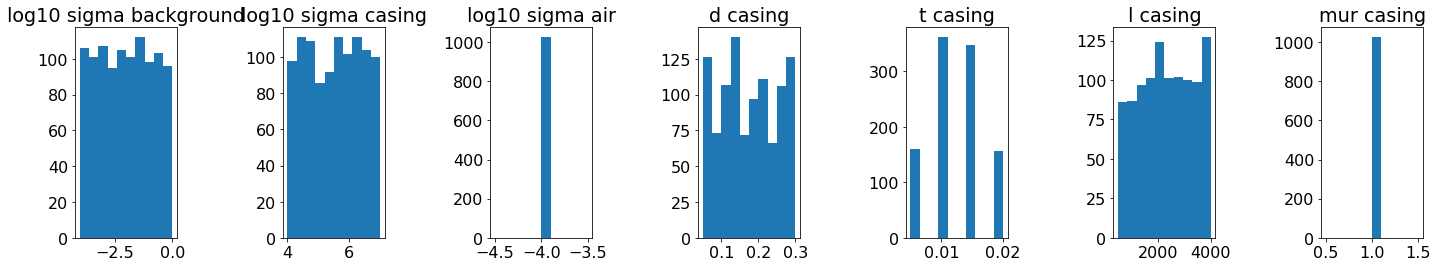

In [5]:
fig, ax = plt.subplots(1, len(df.keys()), figsize=(20, 4))

for i, key in enumerate(df.keys()):
    ax[i].hist(df[key])
    ax[i].set_title(f"{key}".replace("_", " "))

plt.tight_layout()

In [6]:
time_steps = [
    (1e-6, 20), (1e-5, 30), (3e-5, 30), (1e-4, 40), (3e-4, 30), (1e-3, 20), (1e-2, 15)
]

In [7]:
# pick a single model to try training on 
trial_index = 5  # a 1200 m long well (relatively short --> fast simulations)

trial_directory = f"{data_directory}/trial_{trial_index}"

In [8]:
def load_trial(trial_directory):
    
    # model parameters
    with open(f"{trial_directory}/casing.json") as f: 
        params = json.load(f)
    casing = casing_sim.model.CasingInHalfspace.deserialize(params, trusted=True)
    
    with open(f"{trial_directory}/approx_casing.json") as f: 
        params = json.load(f)
    approx_casing = casing_sim.model.CasingInHalfspace.deserialize(params, trusted=True)

    model_dict = {
        "casing": casing, 
        "approx_casing": approx_casing
    }
    
    with open(f"{trial_directory}/simulation_approx_casing.json") as f:
        simulation_params = json.load(f)

    sim = tdem.Problem3D_j.deserialize(simulation_params, trusted=True)
    sim.survey.source_list = sim.survey.source_list # HAck to trigger the validator 
    mesh = sim.mesh
    
    # load up the fields
    fields_dict = {}
    for key in model_dict.keys():
        print(key)
        sim.sigma = model_dict[key].sigma(mesh)
        f = np.load(f"{trial_directory}/{key}_fields.npy")
        fields_dict[key] = sim.fieldsPair(sim)
        fields_dict[key][:, "jSolution", :] = f
    
    return model_dict, fields_dict, sim, mesh 

In [9]:
model_dict, fields_dict, sim, mesh = load_trial(trial_directory)

casing
approx_casing


In [10]:
model_names = list(model_dict.keys())

In [11]:
viewer = casing_sim.FieldsViewer(
    mesh=mesh, model_parameters_dict=model_dict, survey_dict={key: sim.survey for key in model_names}, 
    fields_dict=fields_dict, model_keys=model_names, primary_key="casing"
)

In [12]:
out1 = viewer.widget_cross_section(
    defaults={
        "max_depth":1.1*model_dict["casing"].casing_l,
        "min_depth":-10,
        "max_r":0.15,
        "theta_ind":3, 
        "view":"j"
    }
)
out1

interactive(children=(FloatText(value=0.15, description='max_r'), FloatText(value=-10.0, description='min_dept…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [17]:
x = np.load(f"{trial_directory}/x.npy")
z = np.load(f"{trial_directory}/z.npy")
t = np.logspace(-6, -2, 128)
j_difference = np.load(f"{trial_directory}/j_difference.npy")

In [30]:
j = j_difference.reshape(len(x)*len(z)*2, len(t), order="F")

In [33]:
jx = j_difference[:len(x)*len(z)*len(t)].reshape(len(x), len(z), len(t), order="F")
jz = j_difference[len(x)*len(z)*len(t):].reshape(len(x), len(z), len(t), order="F")

ValueError: 'u' and 'v' must be of shape 'Grid(x,y)'

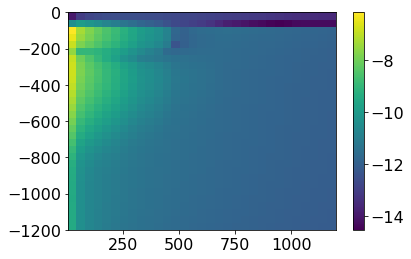

In [35]:
tind = 50

amplitude = np.sqrt(jx[:, :, tind]**2 + jz[:, :, tind]**2)
fig, ax = plt.subplots(1, 1)
plt.colorbar(ax.pcolormesh(x, z, np.log10(amplitude).T))
ax.streamplot(x, z, jx[:, :, tind].T, jz[:, :, tind].T, color="k")
